In [5]:
import sys
sys.path.append("..")

In [6]:
import numpy as np
import logging
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

from recnn.preprocessing import permute_by_pt
from recnn.preprocessing import extract
from recnn.recnn import grnn_transform_gated
from recnn.recnn import grnn_predict_gated

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

In [26]:
filename_train = "../data/w-vs-qcd/anti-kt/antikt-train.pickle-py27-anti-kt"
filename_test = "../data/w-vs-qcd/anti-kt/antikt-test.pickle-py27-anti-kt"

rng = check_random_state(1)

# Make training data
print("Loading training data...")

fd = open(filename_train, "rb")
X, y = pickle.load(fd)
fd.close()
y = np.array(y)

print("\tfilename = %s" % filename_train)
print("\tX size = %d" % len(X))
print("\ty size = %d" % len(y))

# Preprocessing 
print("Preprocessing...")
X = [extract(permute_by_pt(jet)) for jet in X]
tf = RobustScaler().fit(np.vstack([jet["content"] for jet in X]))

for jet in X:
    jet["content"] = tf.transform(jet["content"])

# Make test data 
print("Loading test data...")

fd = open(filename_test, "rb")
X, y = pickle.load(fd)
fd.close()
y = np.array(y)

print("\tfilename = %s" % filename_test)
print("\tX size = %d" % len(X))
print("\ty size = %d" % len(y))

# Preprocessing 
print("Preprocessing...")
X = [extract(permute_by_pt(jet)) for jet in X]

for jet in X:
    jet["content"] = tf.transform(jet["content"])

Loading training data...
	filename = ../data/w-vs-qcd/anti-kt/antikt-train.pickle-py27-anti-kt
	X size = 180000
	y size = 180000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/anti-kt/antikt-test.pickle-py27-anti-kt
	X size = 20000
	y size = 20000
Preprocessing...


# Visualization

## Gated

In [4]:
# Loading model 
print("Loading model...")

filename_model = "../models/n_hidden/w-gated-n_hidden=40.pickle"
fd = open(filename_model, "rb")
params = pickle.load(fd)
fd.close()

print("\tfilename = %s" % filename_model)

Loading model...
	filename = ../models/n_hidden/w-gated-n_hidden=40.pickle


In [5]:
from graphviz import Digraph

def plot_jet_gated(params, jet, index=0):
    # Map node_id to position (i, j) in z and r
    states = grnn_transform_gated(params, [jet], return_states=True)
    content = tf.inverse_transform(jet["content"])
    levels = states["levels"]
    z = states["z"]
    r = states["r"]
    
    mapping = {}
    for i, level in enumerate(levels[-2::-1]):  # last level includes leaves only
        for j, node in enumerate(level):
            mapping[node] = (i, j)
    
    # Build graph recursively
    dot = Digraph(graph_attr={"rank": "flow", "remincross": "true"}, 
                  edge_attr={"arrowsize": "0.25"}, 
                  format="png")
    
    def _rec(jet, parent, node_id, parent_z, parent_r):
        # Get gates
        if jet["tree"][node_id, 0] != -1:
            r_i = r[mapping[node_id][0]][mapping[node_id][1]]
            r_L = r_i[:40][index]
            r_R = r_i[40:80][index]
            r_N = r_i[80:][index]

            z_i = z[mapping[node_id][0]][mapping[node_id][1]]
            z_H = z_i[:, 0][index]
            z_L = z_i[:, 1][index]
            z_R = z_i[:, 2][index]
            z_N = z_i[:, 3][index]

        else:
            z_N = 1.0
        
        # Build subgraph
        sub = Digraph(graph_attr={"rank": "flow"}, 
                      node_attr={"fixedsize": "true", 
                                 "label": "", 
                                 "height": "0.1", 
                                 "width": "0.1"},
                      edge_attr={"arrowsize": "0.25"})
        
        size = "%.4f" % max(0.1, (content[node_id, 3] ** 0.5) / 50.)
        sub.node("%d" % node_id, width=size, height=size)
        sub.node("%d-N" % node_id, shape="diamond")
        sub.edge("%d" % node_id, "%d-N" % node_id, 
                 color="#0000FF%.2x" % int(16+239*z_N))
        
        if jet["tree"][node_id, 0] != -1:
            sub.node("%d-H" % node_id, shape="square")
            sub.edge("%d" % node_id, "%d-H" % node_id, 
                     color="#0000FF%.2x" % int(16+239*z_H))
            sub.edge("%d-H" % node_id, "%d-N" % node_id, style="dashed", constraint="false",
                     color="#FF0000%.2x" % int(16+239*r_N))
            
        dot.subgraph(sub)
        
        # Connect to parent
        if parent >= 0:
            dot.edge("%d" % parent, "%d" % node_id, 
                     color="#0000FF%.2x" % int(16+239*parent_z))
            dot.edge("%d-H" % parent, "%d" % node_id, style="dashed",
                     color="#FF0000%.2x" % int(16+239*parent_r))
            
        # Recursive calls
        if jet["tree"][node_id, 0] != -1:
            _rec(jet, node_id, jet["tree"][node_id, 0], z_L, r_L)
            _rec(jet, node_id, jet["tree"][node_id, 1], z_R, r_R)
        
    _rec(jet, -1, jet["root_id"], None, None) 
    
    return dot

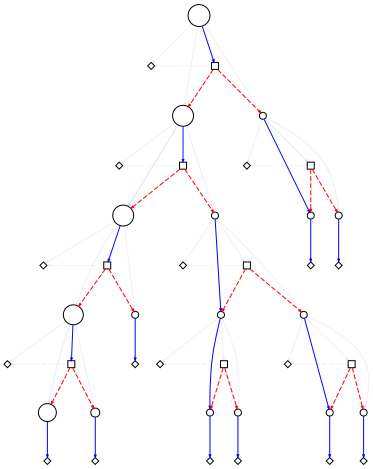

In [6]:
jet_id = np.argmin([len(jet["tree"]) if len(jet["tree"]) > 15 else 1000 for jet in X])
plot_jet_gated(params, X[jet_id], index=22)

## Simple

In [27]:
# Loading model 
print("Loading model...")

#filename_model = "../models/trimming/w-kt-1.pickle"
filename_model = "../models/trimming/w-anti-kt-1.pickle"
fd = open(filename_model, "rb")
params = pickle.load(fd)
fd.close()

print("\tfilename = %s" % filename_model)

Loading model...
	filename = ../models/trimming/w-anti-kt-1.pickle


In [28]:
from recnn.recnn import grnn_predict_simple
from sklearn.metrics import roc_auc_score
roc_auc_score(y, grnn_predict_simple(params, X))

0.87886716000000009

In [29]:
import autograd as ag
import autograd.numpy as np
from recnn.recnn import log_loss, relu, sigmoid


def get_branch(tree, target, node_id, is_left):
    if target == node_id:
        return [(node_id, is_left)]
    elif tree[node_id, 0] == -1:
        return False
    else:
        left_result = get_branch(tree, target, tree[node_id, 0], True)
        right_result = get_branch(tree, target, tree[node_id, 1], False)
        
        if left_result:
            return [(node_id, is_left)] + left_result
        elif right_result:
            return [(node_id, is_left)] + right_result
        else:
            return False  


def grnn_embeddings(content, tree, params):
    embeddings = {}
    
    def _rec(node_id):
        u_k = relu(np.dot(params["W_u"], content[node_id].T).T + 
                   params["b_u"]).reshape(1, -1)
        
        if tree[node_id, 0] == -1:
            embeddings[node_id] = u_k
            return u_k 
        
        else:
            h_L = _rec(tree[node_id, 0])
            h_R = _rec(tree[node_id, 1])
            h = relu(np.dot(params["W_h"],
                            np.hstack((h_L, h_R, u_k)).T).T +
                     params["b_h"])
            embeddings[node_id] = h
            return h
        
    _rec(0)
    return embeddings


def make_dL_dh(content, tree, params, target):
    branch = get_branch(tree, target, 0, True)
    embeddings = grnn_embeddings(content, tree, params)
    
    def f(v):
        e = v
        
        for i, (node_id, is_left) in enumerate(branch[::-1]):
            if i == 0:
                e = v
                was_left = is_left
                
            elif i > 0:
                u_k = relu(np.dot(params["W_u"], content[node_id].T).T + 
                           params["b_u"]).reshape(1, -1)
                
                if was_left:
                    h_L = e
                    h_R = embeddings[tree[node_id, 1]]
                    
                else:
                    h_L = embeddings[tree[node_id, 0]]
                    h_R = e
                    
                h = relu(np.dot(params["W_h"], 
                                np.hstack((h_L, h_R, u_k)).T).T + 
                         params["b_h"])
                
                e = h
                was_left = is_left
                
        h = e
        h = relu(np.dot(params["W_clf"][0], h.T).T + params["b_clf"][0])
        h = relu(np.dot(params["W_clf"][1], h.T).T + params["b_clf"][1])
        h = sigmoid(np.dot(params["W_clf"][2], h.T).T + params["b_clf"][2])
        
        return h.ravel()
    
    df = ag.grad(f)
    
    return df


def make_dL_du(content, tree, params, target):
    branch = get_branch(tree, target, 0, True)
    embeddings = grnn_embeddings(content, tree, params)
    
    def f(v):
        e = v
        
        for i, (node_id, is_left) in enumerate(branch[::-1]):
            if i == 0:
                if tree[node_id, 0] == -1:
                    e = relu(np.dot(params["W_u"], v.T).T + 
                             params["b_u"]).reshape(1, -1)
                    
                else:
                    u_k = relu(np.dot(params["W_u"], v.T).T + 
                               params["b_u"]).reshape(1, -1)
                    h_L = embeddings[tree[node_id, 0]]
                    h_R = embeddings[tree[node_id, 1]]
                    h = relu(np.dot(params["W_h"], 
                                    np.hstack((h_L, h_R, u_k)).T).T + 
                             params["b_h"])
                    e = h
                
                was_left = is_left
                
            elif i > 0:
                u_k = relu(np.dot(params["W_u"], content[node_id].T).T + 
                           params["b_u"]).reshape(1, -1)
                
                if was_left:
                    h_L = e
                    h_R = embeddings[tree[node_id, 1]]
                    
                else:
                    h_L = embeddings[tree[node_id, 0]]
                    h_R = e
                    
                h = relu(np.dot(params["W_h"], 
                                np.hstack((h_L, h_R, u_k)).T).T + 
                         params["b_h"])
                
                e = h
                was_left = is_left
                
        h = e
        h = relu(np.dot(params["W_clf"][0], h.T).T + params["b_clf"][0])
        h = relu(np.dot(params["W_clf"][1], h.T).T + params["b_clf"][1])
        h = sigmoid(np.dot(params["W_clf"][2], h.T).T + params["b_clf"][2])

        return h.ravel()
    
    df = ag.grad(f)
        
    return df

In [30]:
from graphviz import Digraph

import matplotlib as mpl
import matplotlib.cm as cm


norm = mpl.colors.Normalize(vmin=0.001, vmax=2.0)
cmap = cm.inferno_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

def number_to_color(x):
    color = m.to_rgba(x)
    return "#%.2x%.2x%.2x%.2x" % (int(255*color[0]), 
                                  int(255*color[1]), 
                                  int(255*color[2]), 
                                  int(255*color[3]))

def plot_jet_simple(params, jet, label=None):   
    content = tf.inverse_transform(jet["content"])
    embeddings = grnn_embeddings(jet["content"], jet["tree"], params)
    
    # Build graph recursively
    dot = Digraph(graph_attr={"rank": "flow"}, 
                  edge_attr={"arrowsize": "0.5", "fontsize": "8.0"}, 
                  node_attr={"style": "filled"},
                  format="png")
    
    df = make_dL_dh(jet["content"], jet["tree"], params, 0)
    norm_root = (df(embeddings[0]) ** 2).sum() ** 0.5 
    
    if label:
        dot.graph_attr["label"] = label
    
    def _rec(jet, parent, node_id): 
        df = make_dL_du(jet["content"], jet["tree"], params, node_id)
        norm_u = (df(jet["content"][node_id]) ** 2).sum() ** 0.5 / norm_root
        
        df = make_dL_dh(jet["content"], jet["tree"], params, node_id)
        norm_h = (df(embeddings[node_id]) ** 2).sum() ** 0.5 / norm_root
        
        # Build subgraph
        sub = Digraph(graph_attr={"rank": "flow"}, 
                      node_attr={"fixedsize": "true", 
                                 "label": "", 
                                 "height": "0.1", 
                                 "width": "0.1",
                                 "style": "filled"},
                      edge_attr={"arrowsize": "0.5",
                                 "fontsize": "8.0"})
        
        size = "%.4f" % max(0.1, norm_h / 2.0)
        sub.node("%d" % node_id, width=size, height=size, shape="circle",
                 color=number_to_color(norm_h)) 
        size = "%.4f" % max(0.1, norm_u / 2.0)
        sub.node("%d-N" % node_id, width=size, height=size, shape="diamond", 
                 color=number_to_color(norm_u))
        sub.edge("%d" % node_id, "%d-N" % node_id, 
                 color=number_to_color(norm_u),
                 label="%.4f" % norm_u)
        
        dot.subgraph(sub)
        
        # Connect to parent
        if parent >= 0:            
            dot.edge("%d" % parent, "%d" % node_id, 
                     color=number_to_color(norm_h),
                     label="%.4f" % norm_h)
            
        # Recursive calls
        if jet["tree"][node_id, 0] != -1:
            _rec(jet, node_id, jet["tree"][node_id, 0])
            _rec(jet, node_id, jet["tree"][node_id, 1])
        
    _rec(jet, -1, jet["root_id"]) 
    
    return dot

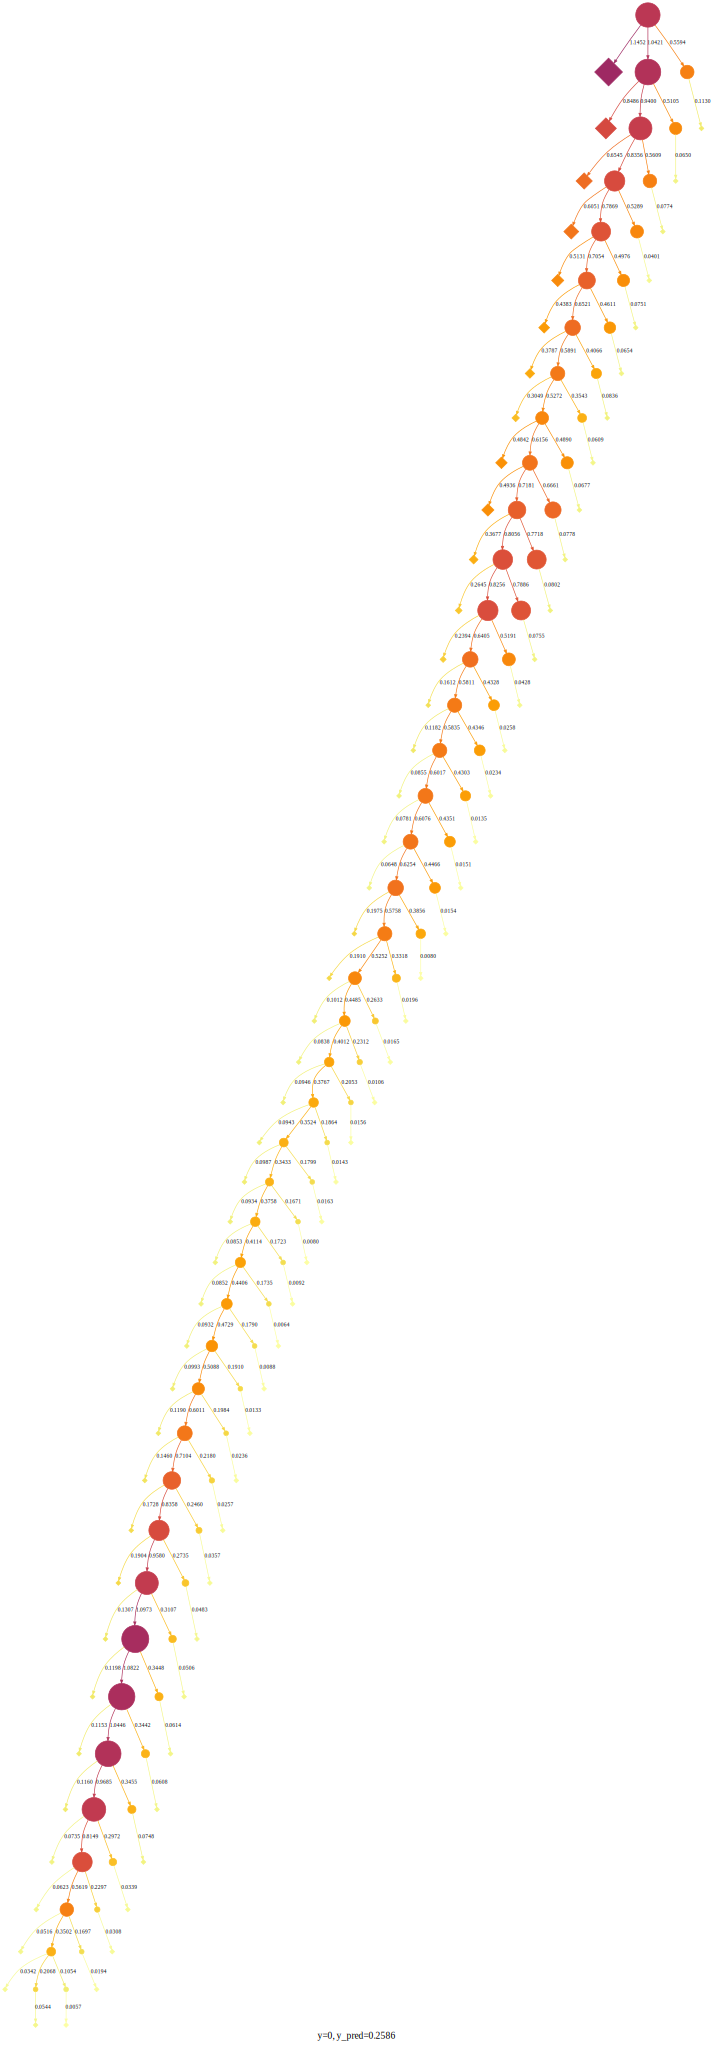

In [31]:
jet_id=0
plot_jet_simple(params, X[jet_id],
                          label="y=%d, y_pred=%.4f" % (y[jet_id], 
                                                       grnn_predict_simple(params, [X[jet_id]])[0]))

In [32]:
np.random.seed(123)

for jet_id in np.random.permutation(len(X))[:20]:
    dot = plot_jet_simple(params, X[jet_id],
                          label="y=%d, y_pred=%.4f" % (y[jet_id], 
                                                       grnn_predict_simple(params, [X[jet_id]])[0]))
    dot.render("figures/%d-anti-kt" % jet_id)